## Начальные этапы анализа

([Задание для семинара](#scrollTo=joDB5Pie_Omo&line=1&uniqifier=1), 
[Домашнее задание](#scrollTo=NPQ0LuKMHrHj&line=1&uniqifier=1))

Разберем, какие инструменты пригодятся для начальных этапов анализа текста. 

Создадим простой классификатор тональности текста. В качестве данных возьмем датасет RuSentiment http://text-machine.cs.uml.edu/projects/rusentiment/

In [ ]:
%%bash

wget -q https://github.com/strawberrypie/rusentiment/raw/master/Dataset/rusentiment_random_posts.csv
wget -q https://raw.githubusercontent.com/strawberrypie/rusentiment/master/Dataset/rusentiment_test.csv

In [ ]:
import pandas as pd

train = pd.read_csv('rusentiment_random_posts.csv')
test = pd.read_csv('rusentiment_test.csv')

In [ ]:
test.head()

,label,text
0,neutral,"Александр, тебе к лицу эта пушка :)\n"
1,positive,"Скоро ты вернешься домой, грязный, не бритый н..."
2,neutral,помниш...))
3,skip,Мы просто с [id12210212|Елисеем] психанули )...
4,speech,"ой, прости забыла поздравить, с праздничьком, ..."


In [ ]:
test.iloc[12].text, test.iloc[12].label

('Проект Анастасия. Часть 1 — на Яндекс.Видео\nВОТ ОДИН ИЗ ИНТЕРЕСНЫХ КОММЕНТАРИЕВ К ФИЛЬМУ:\nк сожалению отсутствие дара Различения у людей ввиду низкого уровня нравственности не позволяет людям отделить идею самодостаточности жизни на Земле от всего, что на неё не без помощи Мегре накрутили ловкие и умные кукловоды человечества.\nЧеловек имеет право быть счастливым на Земле, но он должен уметь при этом уметь Различать Добро и Зло\nСмотрите фильм - это лучшая проверка самих себя на вшивость',
 'neutral')

In [ ]:
test.label.value_counts()

neutral     1420
positive     536
speech       407
skip         346
negative     258
Name: label, dtype: int64

## Этап 1. Графематический анализ 

Первый уровень анализа текста – графематический анализ: разделение текста на абзацы,  предложения, токены. Особое внимание стоит обратить на токенизацию:

- Если не используются сторонние анализаторы верхнего уровня (морфологический,  синтаксический, NER и т.д.), для токенизации текста используют любую достаточно быструю и качественную реализацию из сторонних библиотек или регулярные выражения. Токенами могут быть слова или части слов. 

- Если в алгоритме обработки текста после токенизации присутствует вызов стороннего  лингвистического анализатора, для достижения наилучшего качества анализа желательно использовать метод токенизации, которым пользовались разработчики этого  анализатора, или наиболее приближенный к токенизации в данных, на основе которых  разработан анализатор. Набор правил, имитирующий сегментацию в русскоязычных размеченных морфосинтаксических корпусах, реализован в токенизаторе [razdel](https://github.com/natasha/razdel).

- Присутствие в алгоритме обработки текста анализаторов более высокого уровня (морфологического, синтаксического, семантического и т.д.) подразумевает, что токеном предложения является слово. Однако в задачах, не подразумевающих работу с отдельными  словами (например, классификация тональности сообщения!), может быть полезно рассматривать в качестве токенов части слова. Это позволяет учитывать при анализе:
 - формы слова / однокоренные слова, отсутствующие в словаре,
 - опечатки (избавляя от необходимости вызова медленных внешних модулей)

  Для разделения текстов на подслова существуют эффективные реализации алгоритмов [BPE](https://github.com/VKCOM/YouTokenToMe), [Wordpiece](https://github.com/huggingface/tokenizers) и др.



### Способ 1. Использовать токенизаторы и сегментаторы из мультиязычных библиотек анализа текстов: NLTK, Spacy, Stanza и т.д.

Обычно используются при обучении или если качество анализа - не первостепенная задача; заводятся в две строки. Можно использовать перед токенизацией на подтокены (чтобы пунктуация не считалась частью слова).

In [ ]:
import nltk

nltk.download('punkt')
tokens = nltk.word_tokenize(test.iloc[12].text)
sentences = nltk.sent_tokenize(test.iloc[12].text)

print('Tokens:', tokens)
print()
print('Sentences:', sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Tokens: ['Проект', 'Анастасия', '.', 'Часть', '1', '—', 'на', 'Яндекс.Видео', 'ВОТ', 'ОДИН', 'ИЗ', 'ИНТЕРЕСНЫХ', 'КОММЕНТАРИЕВ', 'К', 'ФИЛЬМУ', ':', 'к', 'сожалению', 'отсутствие', 'дара', 'Различения', 'у', 'людей', 'ввиду', 'низкого', 'уровня', 'нравственности', 'не', 'позволяет', 'людям', 'отделить', 'идею', 'самодостаточности', 'жизни', 'на', 'Земле', 'от', 'всего', ',', 'что', 'на', 'неё', 'не', 'без', 'помощи', 'Мегре', 'накрутили', 'ловкие', 'и', 'умные', 'кукловоды', 'человечества', '.', 'Человек', 'имеет', 'право', 'быть', 'счастливым', 'на', 'Земле', ',', 'но', 'он', 'должен', 'уметь', 'при', 'этом', 'уметь', 'Различать', 'Добро', 'и', 'Зло', 'Смотрите', 'фильм', '-', 'это', 'лучшая', 'проверка', 'самих', 'себя', 'на', 'вшивость']

Sentences: ['Проект Анастасия.', 'Часть 1 — на Яндекс.Видео\nВОТ ОДИН ИЗ ИНТЕРЕСНЫХ КОММЕНТАРИЕВ К ФИЛЬМУ:\nк сожалению отсутствие дара Различ

In [ ]:
train['text_tokenized'] = train.text.map(nltk.word_tokenize)
test['text_tokenized'] = test.text.map(nltk.word_tokenize)

In [ ]:
test.head()

,label,text,text_tokenized
0,neutral,"Александр, тебе к лицу эта пушка :)\n","[Александр, ,, тебе, к, лицу, эта, пушка, :, )]"
1,positive,"Скоро ты вернешься домой, грязный, не бритый н...","[Скоро, ты, вернешься, домой, ,, грязный, ,, н..."
2,neutral,помниш...)),"[помниш, ..., ), )]"
3,skip,Мы просто с [id12210212|Елисеем] психанули )...,"[Мы, просто, с, [, id12210212|Елисеем, ], псих..."
4,speech,"ой, прости забыла поздравить, с праздничьком, ...","[ой, ,, прости, забыла, поздравить, ,, с, праз..."


### Способ 2. Воспользоваться нейросетевыми пайплайнами: 
- UDPipe http://ufal.mff.cuni.cz/udpipe
- TurkuNLP https://turkunlp.org/Turku-neural-parser-pipeline/

Оба содержат предобученные модели для каждого шага, от токенизации до синтаксиса зависимостей. 

In [ ]:
%%bash

# установка библиотеки udpipe и библиотеки текстового анализа isanlp с оберткой для нее
pip install git+https://github.com/IINemo/isanlp.git ufal.udpipe
# загрузка модели udpipe-2.5 для русского языка
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/russian-syntagrus-ud-2.5-191206.udpipe

In [ ]:
from isanlp.processor_udpipe import ProcessorUDPipe

udpipe = ProcessorUDPipe('russian-syntagrus-ud-2.5-191206.udpipe')
result = udpipe(test.iloc[12].text)
tokens = [token.text for token in result['tokens']]
sentences = [tokens[sentence.begin:sentence.end] for sentence in result['sentences']]

print('Tokens:', tokens)
print('Sentences:', sentences)

Tokens: ['Проект', 'Анастасия', '.', 'Часть', '1', '—', 'на', 'Яндекс', '.', 'Видео', 'ВОТ', 'ОДИН', 'ИЗ', 'ИНТЕРЕСНЫХ', 'КОММЕНТАРИЕВ', 'К', 'ФИЛЬМУ', ':', 'к', 'сожалению', 'отсутствие', 'дара', 'Различения', 'у', 'людей', 'ввиду', 'низкого', 'уровня', 'нравственности', 'не', 'позволяет', 'людям', 'отделить', 'идею', 'самодостаточности', 'жизни', 'на', 'Земле', 'от', 'всего', ',', 'что', 'на', 'неё', 'не', 'без', 'помощи', 'Мегре', 'накрутили', 'ловкие', 'и', 'умные', 'кукловоды', 'человечества', '.', 'Человек', 'имеет', 'право', 'быть', 'счастливым', 'на', 'Земле', ',', 'но', 'он', 'должен', 'уметь', 'при', 'этом', 'уметь', 'Различать', 'Добро', 'и', 'Зло', 'Смотрите', 'фильм', '-', 'это', 'лучшая', 'проверка', 'самих', 'себя', 'на', 'вшивость']
Sentences: [['Проект', 'Анастасия', '.'], ['Часть', '1', '—', 'на', 'Яндекс', '.', 'Видео', 'ВОТ', 'ОДИН', 'ИЗ', 'ИНТЕРЕСНЫХ', 'КОММЕНТАРИЕВ', 'К', 'ФИЛЬМУ', ':', 'к', 'сожалению', 'отсутствие', 'дара', 'Различения', 'у', 'людей', 'ввиду', '

### Способ 3. Поделить текст на подтокены, используя символьную статистику корпуса: 

**Задание (Семинар, 2 балла):** дополните код, чтобы токенизировать обучающую и тестовую выборки.

In [ ]:
! pip install youtokentome

In [ ]:
import youtokentome as yttm
import re

MODELNAME = 'bpe.model'

def prepare_text(text):
  return ' '.join(re.split(r'[\W]+', text.lower()))

def train_bpe(texts, vocab_size=10000):
    texts_filename = 'texts.txt'
    with open(texts_filename, 'w') as f:
        for text in texts:
            f.write(prepare_text(text) + '\n')
    
    yttm.BPE.train(data=texts_filename, vocab_size=vocab_size, model=MODELNAME)
            
train_bpe(train.text)
bpe = yttm.BPE(model=MODELNAME)

def bpe_tokenize(text):
    #########################
    # ToDO: implement your tokenization function here using the model

train['bpe'] = train.text.map(bpe_tokenize)
test['bpe'] = test.text.map(bpe_tokenize)

In [ ]:
train.head()

,label,text,text_tokenized,bpe
0,negative,"А попа подозревала давно,что ты с кавказа..пер...","[А, попа, подозревала, давно, ,, что, ты, с, к...",▁а ▁попа ▁подоз ре вала ▁давно ▁что ▁ты ▁с ▁ка...
1,speech,З прошедшим Днем Ангела)))))))),"[З, прошедшим, Днем, Ангела, ), ), ), ), ), ),...",▁з ▁прошедшим ▁днем ▁ангела
2,skip,Два дня до отлёта с острова!!!!!!!,"[Два, дня, до, отлёта, с, острова, !, !, !, !,...",▁два ▁дня ▁до ▁от лё та ▁с ▁острова
3,negative,"Блин, почему эта жизнь столь не справедлива ((((","[Блин, ,, почему, эта, жизнь, столь, не, справ...",▁блин ▁почему ▁эта ▁жизнь ▁столь ▁не ▁спра вед...
4,skip,где еще встречать свой день рождения как не на...,"[где, еще, встречать, свой, день, рождения, ка...",▁где ▁еще ▁встречать ▁свой ▁день ▁рождения ▁ка...


### Создадим классификатор для определения тональности текста по токенам, которые в нем присутствуют

#### Стоп-слова (предлоги, междометия и т.д.) удаляем, они только добавляют шум.

При обработке текста не всегда полезен весь набор его токенов. В зависимости от задачи,  шумом могут считаться:
1. Знаки препинания. В Python можно использовать встроенный словарь пунктуации
``string.punctuation`` из модуля ``string``
2. Универсальные стоп-слова: союзы, предлоги и т.д. См. ``nltk.corpus.stopwords.words('russian')``
3. Характерные для корпуса частотные стоп-слова. Например, в задаче классификации  такими словами будут часто встречающиеся слова, одинаково представленные во всех  классах.
4. Токены, которые можно заменить общим служебным токеном: гиперссылки, адреса  электронной почты, эмотиконы, имена и фамилии, специальные символы. Диакритика (в том числе буква Ё в русском языке), как правило, чистится еще на этапе предобработки перед токенизацией; вместе с удалением мусорных символов.

До обработки: ``Почитай , это про TF-IDF : https://ru.wikipedia.org/wiki/TF-IDF ☝️ 🧐 =)`` 

После: ``Почитай это TF-IDF _LINK_ _EMOJI _EMOJI_ _EMOJI_``

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('russian')

train['text_tokenized_clean'] = train.text_tokenized.map(lambda row: ' '.join(
    [token for token in row if not token.lower() in stopwords]))

test['text_tokenized_clean'] = test.text_tokenized.map(lambda row: ' '.join(
    [token for token in row if not token.lower() in stopwords]))

In [ ]:
train.text_tokenized_clean.head()

0    попа подозревала давно , кавказа..перестану об...
1              З прошедшим Днем Ангела ) ) ) ) ) ) ) )
2                     дня отлёта острова ! ! ! ! ! ! !
3    Блин , почему эта жизнь столь справедлива ( ( ( (
4        встречать свой день рождения кладбище ) ) ) )
Name: text_tokenized_clean, dtype: object

#### Визуализируем частотности токенов в разных классах.

In [ ]:
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

def print_cloud(texts):
    wordcloud = WordCloud(width = 500, height = 200, 
                          random_state = 40, max_font_size = 80,
                          background_color="white", regexp=r"[\w\d\(\)]+").generate(texts)
    plt.figure(figsize =(10,7))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

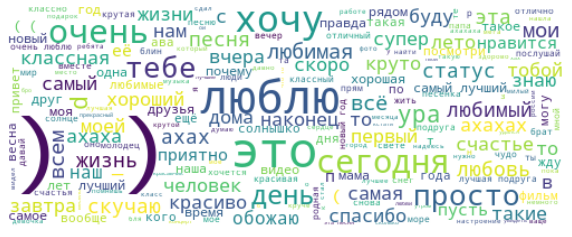

In [ ]:
positive = train[train.label == 'positive'].text_tokenized_clean.to_string().lower()
negative = train[train.label == 'negative'].text_tokenized_clean.to_string().lower()

print_cloud(positive)

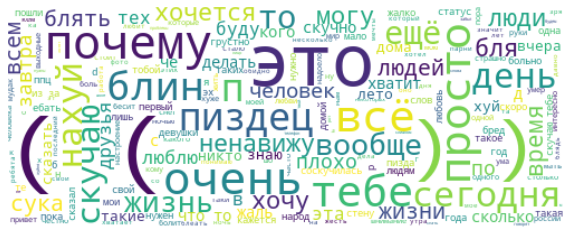

In [ ]:
print_cloud(negative)

#### Обучаем линейный классификатор; признаки - мешок слов (BoW) 

Для решения практических задач (сравнения высказываний, классификации, 
кластеризации и т.д.) можно преобразовывать тексты и отдельные токены в векторы.
Основные методы векторизации текстов:
1. Базовый метод Bag-of-Words: вектор встречаемости n-грамм токенов в тексте
2. TF-IDF, учитывающий частотность слова в документе и во всем корпусе
3. Усредненные (с весами и без) векторные представления слов
4. Извлечение выходов внутреннего слоя обученной нейронной сети, на входе которой – векторные представления слов текста. Сюда относятся внутренние представления  автоэнкодеров, предобученных трансформеров и не предназначенных  специально для получения эмбеддингов предобученных моделей.

Среди множества методов построения векторных представлений слов в настоящее время наиболее часто используются:
1. Статические модели дистрибутивной  семантики, основанные на алгоритмах  CBoW и Skipgram: word2vec, fasttext.  Токен соответствует одному и тому же  вектору вне зависимости от контекста,  в котором он встретился.
2. Динамические контекстные модели-трансформеры (не являющиеся предметом этого курса): BERT, RoBERTa, T5 и др. Вектор токена формируется на основе контекста предложения.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True, tokenizer=lambda x: x.split(' '), ngram_range=(1,3), max_features=20000)
cv.fit(train['text_tokenized_clean'])
X_train = cv.transform(train['text_tokenized_clean'])
X_test = cv.transform(test['text_tokenized_clean'])
y_train = train['label'].values
y_test = test['label'].values

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_test1 = {
 'C':[0.01, 0.1, 0.5, 1.,]
}
gsearch1 = GridSearchCV(estimator = LogisticRegression(solver='liblinear'), 
                        param_grid = param_test1, scoring = 'f1_macro',
                        n_jobs=-1, iid=False, cv=10, verbose=2)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   24.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'C': 1.0}, 0.5929196246896424)

In [ ]:
logreg = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='macro')

0.5918382005136753

## Этап 2. Морфологический анализ 

### Библиотеки для морфологического анализа текстов на русском: 
- pymorphy2 https://pymorphy2.readthedocs.io/en/latest/
- pymystem3 https://github.com/nlpub/pymystem3

In [ ]:
sample = test.iloc[12].text_tokenized[:15]
print(sample)

['Проект', 'Анастасия', '.', 'Часть', '1', '—', 'на', 'Яндекс.Видео', 'ВОТ', 'ОДИН', 'ИЗ', 'ИНТЕРЕСНЫХ', 'КОММЕНТАРИЕВ', 'К', 'ФИЛЬМУ']


In [ ]:
! pip install pymorphy2

In [ ]:
import pymorphy2

morph=pymorphy2.MorphAnalyzer()
[morph.parse(token)[0] for token in sample]

[Parse(word='проект', tag=OpencorporaTag('NOUN,inan,masc sing,nomn'), normal_form='проект', score=0.65625, methods_stack=((<DictionaryAnalyzer>, 'проект', 33, 0),)),
 Parse(word='анастасия', tag=OpencorporaTag('NOUN,anim,masc,Name sing,gent'), normal_form='анастасий', score=0.3333333333333333, methods_stack=((<DictionaryAnalyzer>, 'анастасия', 61, 1),)),
 Parse(word='.', tag=OpencorporaTag('PNCT'), normal_form='.', score=1.0, methods_stack=((<PunctuationAnalyzer>, '.'),)),
 Parse(word='часть', tag=OpencorporaTag('NOUN,inan,femn sing,nomn'), normal_form='часть', score=0.6, methods_stack=((<DictionaryAnalyzer>, 'часть', 3025, 0),)),
 Parse(word='1', tag=OpencorporaTag('NUMB,intg'), normal_form='1', score=1.0, methods_stack=((<NumberAnalyzer>, '1'),)),
 Parse(word='—', tag=OpencorporaTag('PNCT'), normal_form='—', score=1.0, methods_stack=((<PunctuationAnalyzer>, '—'),)),
 Parse(word='на', tag=OpencorporaTag('PREP'), normal_form='на', score=0.99931, methods_stack=((<DictionaryAnalyzer>, 'н

In [ ]:
import pymystem3

mystem=pymystem3.Mystem()
mystem.analyze(' '.join(sample))

In [ ]:
udpipe(' '.join(sample))

### Нормализуем тексты перед классификацией (лемматизация)

In [ ]:
morph=pymorphy2.MorphAnalyzer()

train['text_lemmatized'] = train.text_tokenized_clean.map(
    lambda row: ' '.join([morph.parse(token)[0].normal_form for token in row.split()]))
test['text_lemmatized'] = test.text_tokenized_clean.map(
    lambda row: ' '.join([morph.parse(token)[0].normal_form for token in row.split()]))

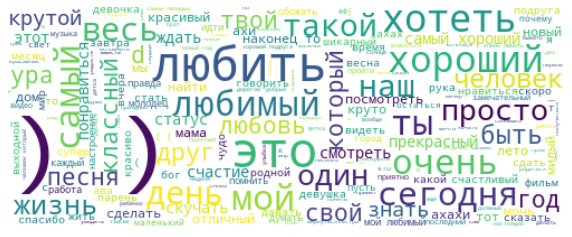

In [ ]:
positive = train[train.label == 'positive'].text_lemmatized.to_string().lower()
negative = train[train.label == 'negative'].text_lemmatized.to_string().lower()

print_cloud(positive)

In [ ]:
train.head()

,label,text,text_tokenized,text_tokenized_clean,text_lemmatized
0,negative,"А попа подозревала давно,что ты с кавказа..пер...","[А, попа, подозревала, давно, ,, что, ты, с, к...","попа подозревала давно , кавказа..перестану об...","поп подозревать давно , кавказа..перестан обща..."
1,speech,З прошедшим Днем Ангела)))))))),"[З, прошедшим, Днем, Ангела, ), ), ), ), ), ),...",З прошедшим Днем Ангела ) ) ) ) ) ) ) ),з прошедшее днём ангел ) ) ) ) ) ) ) )
2,skip,Два дня до отлёта с острова!!!!!!!,"[Два, дня, до, отлёта, с, острова, !, !, !, !,...",дня отлёта острова ! ! ! ! ! ! !,день отлёт остров ! ! ! ! ! ! !
3,negative,"Блин, почему эта жизнь столь не справедлива ((((","[Блин, ,, почему, эта, жизнь, столь, не, справ...","Блин , почему эта жизнь столь справедлива ( ( ( (","блин , почему этот жизнь столь справедливый ( ..."
4,skip,где еще встречать свой день рождения как не на...,"[где, еще, встречать, свой, день, рождения, ка...",встречать свой день рождения кладбище ) ) ) ),встречать свой день рождение кладбище ) ) ) )


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True, tokenizer=lambda x: x.split(' '), ngram_range=(1,3), max_features=20000)
cv.fit(train['text_lemmatized'])
X_train = cv.transform(train['text_lemmatized'])
X_test = cv.transform(test['text_lemmatized'])
y_train = train['label'].values
y_test = test['label'].values

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_test1 = {
 'C':[0.01, 0.1, 0.5, 1.,]
}
gsearch1 = GridSearchCV(estimator = LogisticRegression(solver='liblinear'), 
                        param_grid = param_test1, scoring = 'f1_macro',
                        n_jobs=-1, iid=False, cv=10, verbose=2)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
logreg = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='macro')

0.6106623655663276

61.07 > 59.18

## Домашнее задание (6 баллов)

Улучшить качество линейного классификатора из лабораторного примера (61% на тестовом наборе данных) путем добавления/фильтрации признаков, прокомментировать, почему в данной задаче ваша стратегия выбора признаков привела к лучшему результату. **Для получения максимального балла необходимо достичь не менее 62% макроусредненной F1**.

Решения в форме ноутбуков, где последняя ячейка содержит ответ с текстовым комментарием, присылайте на mipttextanalysis20@gmail.com (ссылкой на colab.research или файлом). 

Решения без штрафа (8 баллов максимум) принимаются до 12.00 22 сентября. Всё, что присылается не в срок, оценивается из максимума 4 балла. Работу, присланную в срок и оцененную не менее чем на 4 балла, можно доделать и досдать на максимум один раз.

Пожалуйста, указывайте фамилию в названии блокнота. Комментарий к решению принимается на русском или английском языке.